In [2]:
import os
import sys
sys.path.append('/home/yang_liu/python_workspace/gaussian-splatting-lightning')

import json
import pickle
import numpy as np
import matplotlib.pyplot as plt
from internal.utils.gaussian_model_loader import GaussianModelLoader

In [3]:
# load model and dataset
model, renderer = GaussianModelLoader.search_and_load(
    "../outputs/citygs2d_sciart",
    sh_degree=3,
    device="cuda",
)
print("Gaussian count: {}".format(model.get_xyz.shape[0]))
xyz = model.get_xyz.cpu().numpy()

Gaussian count: 3655573


In [18]:
traj_path = "../outputs/citygs2d_sciart/mesh/merged_epoch=11-step=30000/traj"
traj_files = os.listdir(traj_path)
traj_files.sort()

w2c, cam_centers = [], []
for traj_file in traj_files:
    with open(os.path.join(traj_path, traj_file), "rb") as f:
        traj = pickle.load(f)
        w2c.append(traj["world_view_transform"])
        cam_center = np.linalg.inv(traj["world_view_transform"])[3, :3]
        cam_centers.append(cam_center)
w2c = np.stack(w2c)
cam_centers = np.stack(cam_centers)
coord_std = np.std(cam_centers, axis=0)
# use dimension with minimum std as the up direction
up_dim = np.argmin(coord_std)
x_dim = (up_dim + 1) % 3
y_dim = (up_dim + 2) % 3
delta_rate = 0.1
x_min = np.min(cam_centers[:, x_dim])
x_max = np.max(cam_centers[:, x_dim])
x_delta = (x_max - x_min) * delta_rate
y_min = np.min(cam_centers[:, y_dim])
y_max = np.max(cam_centers[:, y_dim])
y_delta = (y_max - y_min) * delta_rate

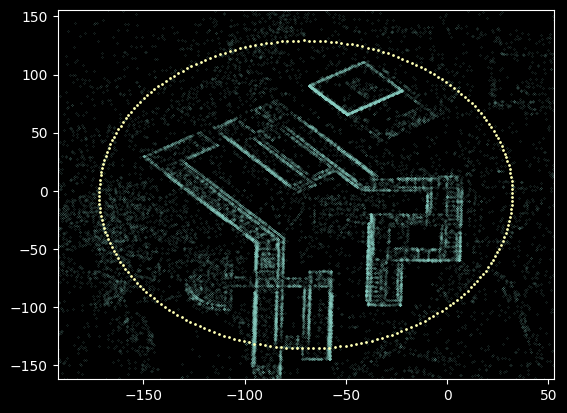

In [19]:
plt.figure()
plt.scatter(xyz[::100, x_dim], xyz[::100, y_dim], s=0.01)
plt.scatter(cam_centers[:, x_dim], cam_centers[:, y_dim], s=1)
plt.xlim(x_min - x_delta, x_max + x_delta)
plt.ylim(y_min - y_delta, y_max + y_delta)
plt.show()